### Imports and main params

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne.channels import find_ch_adjacency
from mne.datasets import sample
from mne.stats import combine_adjacency, spatio_temporal_cluster_test
from mne.viz import plot_compare_evokeds

import os
import pickle
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind
from mne.stats import f_mway_rm, f_threshold_mway_rm

from tqdm import tqdm

mne.set_log_level('warning')

In [9]:
ROOT = '/scratch/alr664/multiple_affix'
os.chdir(ROOT)

mri_dir = os.path.join(ROOT, 'mri')
#stc_dir = os.path.join(ROOT, 'stc_signed')
#stats_dir = os.path.join(ROOT, 'stats')

#subjects = ['R1830', 'R2283', 'R2356', 'R2340', 'R2341', 'R2342', 'R2343', 'R2345', 'R2346', 'R2347', 'R2352', 'R2353', 'R2354', 'R2358', 'R2359', 'R2360', 'R2366', 'R2367', 'R2368', 'R2371']
subjects = [
    "A0394", "A0421", "A0446", "A0451", "A0468", "A0484", "A0495", "A0502", "A0503", "A0508", 
    "A0509", "A0512", "A0513", "A0514", "A0516", "A0517", "A0518", "A0519", "A0520", "A0521", 
    "A0522", "A0523", "A0524", "A0525"
]
print(len(subjects))
#pres_type = 'rsvp' # subset all data to this pres type only
# surprisals = ['high_high','high_low','low_high','low_low']
# colors = {str('high_high'+"_"+pres_type):'tab:blue',
#          str('high_low'+"_"+pres_type):'tab:green',
#          str('low_high'+"_"+pres_type):'tab:red',
#          str('low_low'+"_"+pres_type):'tab:orange'}


# permutation test vars 
tmin = 0
tmax = 0.5
tail = 1
p_thresh = 0.05
n_permutations = 10000

lex_event_ids = {
    '0Suff w/ Lat.': 1,
    '0Suff w/o Lat.': 2,
    '0Suff NW': 4,
    '1Suff w/ Lat.': 11,
    '1Suff w/o Lat.': 12,
    '1Suff PseudoStemNW': 14,
    '1Suff RealStemNW': 15,
    '2Suff w/ Lat.': 21,
    '2Suff w/o Lat.': 22,
    '2Suff Composite': 23,
    '2Suff PseudoStemNW': 24,
    '2Suff RealStemNW': 25,
    'Practice': 99
}


24


### Import epochs and subset by pres_type

In [14]:
# Read data
for i, subject in enumerate(tqdm(subjects)):
                    
    epochs_dir = f'meg/{subject}/epochs/'
    epochs = mne.read_epochs(os.path.join(ROOT, 'meg', subject, f'{subject}_rejection-epo.fif'))
    #epochs = epochs[epochs.metadata.pres_type == pres_type] # subsetting by pres_type

    num_events = len(epochs.events)
    epochs.metadata = pd.DataFrame(index=range(num_events))

    # Step 2: Create the 'Trigger' column
    epochs.metadata['Trigger'] = epochs.events[:, 2]
    
    # Step 3: Map the event IDs to condition labels and create the 'Condition' column
    epochs.metadata['Condition'] = epochs.metadata['Trigger'].map(event_to_label)
    
    #epochs.metadata['full_cond'] = epochs.metadata['cond'] + '_' + epochs.metadata['pres_type'] # create merged condition names

    if i == 0: # initialize variables on the first subject only
        times = epochs.times # get the epochs times
        event_to_label = {v: k for k, v in lex_event_ids.items()}
        
        #print(epochs.metadata)
        conditions = epochs.metadata.Condition.unique()
        epochs_data = np.zeros((len(subjects), len(conditions), 207,  len(times))) # create container for all subj epoch data
        info = epochs[0].info
        
        print('times = ', times)
        print('conditions = ', conditions)
    
    for j, condition in enumerate(conditions):
        epochs_data[i, j] = epochs[epochs.metadata['Condition'] == condition].get_data(copy=True).mean(axis=0) # for each subj, for each cond: get average over trials  (axis 0)
print(epochs_data.shape)

  0%|          | 0/24 [00:00<?, ?it/s]

times =  [-0.2   -0.199 -0.198 -0.197 -0.196 -0.195 -0.194 -0.193 -0.192 -0.191
 -0.19  -0.189 -0.188 -0.187 -0.186 -0.185 -0.184 -0.183 -0.182 -0.181
 -0.18  -0.179 -0.178 -0.177 -0.176 -0.175 -0.174 -0.173 -0.172 -0.171
 -0.17  -0.169 -0.168 -0.167 -0.166 -0.165 -0.164 -0.163 -0.162 -0.161
 -0.16  -0.159 -0.158 -0.157 -0.156 -0.155 -0.154 -0.153 -0.152 -0.151
 -0.15  -0.149 -0.148 -0.147 -0.146 -0.145 -0.144 -0.143 -0.142 -0.141
 -0.14  -0.139 -0.138 -0.137 -0.136 -0.135 -0.134 -0.133 -0.132 -0.131
 -0.13  -0.129 -0.128 -0.127 -0.126 -0.125 -0.124 -0.123 -0.122 -0.121
 -0.12  -0.119 -0.118 -0.117 -0.116 -0.115 -0.114 -0.113 -0.112 -0.111
 -0.11  -0.109 -0.108 -0.107 -0.106 -0.105 -0.104 -0.103 -0.102 -0.101
 -0.1   -0.099 -0.098 -0.097 -0.096 -0.095 -0.094 -0.093 -0.092 -0.091
 -0.09  -0.089 -0.088 -0.087 -0.086 -0.085 -0.084 -0.083 -0.082 -0.081
 -0.08  -0.079 -0.078 -0.077 -0.076 -0.075 -0.074 -0.073 -0.072 -0.071
 -0.07  -0.069 -0.068 -0.067 -0.066 -0.065 -0.064 -0.063 -0.062 -0.0

100%|██████████| 24/24 [08:31<00:00, 21.29s/it]

(24, 12, 207, 801)


In [ ]:
average_waveforms = epochs_data.mean(axis=0)  # average across the subject axis

print(average_waveforms.shape)

evoked_dict = {}
for i, condition in enumerate(conditions):
    evoked_dict[condition] = mne.EvokedArray(average_waveforms[i], info, tmin=times[0])

mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='Evoked Response') # need to set custom colors for all conds

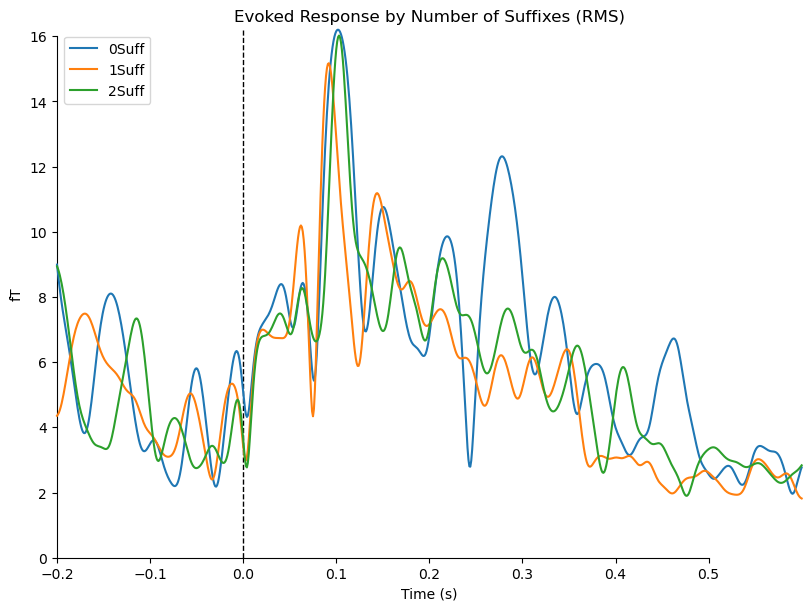

In [25]:
# for simple plotting
import matplotlib.pyplot as plt
suffix_groups = {
    '0Suff': [],
    '1Suff': [],
    '2Suff': []
}

for i, condition in enumerate(conditions):
    if condition.startswith('0Suff'):
        suffix_groups['0Suff'].append(i)
    elif condition.startswith('1Suff'):
        suffix_groups['1Suff'].append(i)
    elif condition.startswith('2Suff'):
        suffix_groups['2Suff'].append(i)

average_waveforms = {}
for suffix, indices in suffix_groups.items():
    group_data = epochs_data[indices].mean(axis=0)  # average across the condition axis
    average_waveforms[suffix] = group_data.mean(axis=0)  # average across the epoch axis

evoked_dict = {}
for suffix, data in average_waveforms.items():
    evoked_dict[suffix] = mne.EvokedArray(data, info, tmin=times[0])

# Plot the evoked responses
fig = mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='Evoked Response by Number of Suffixes')

fig[0].savefig('suffixation.pdf')

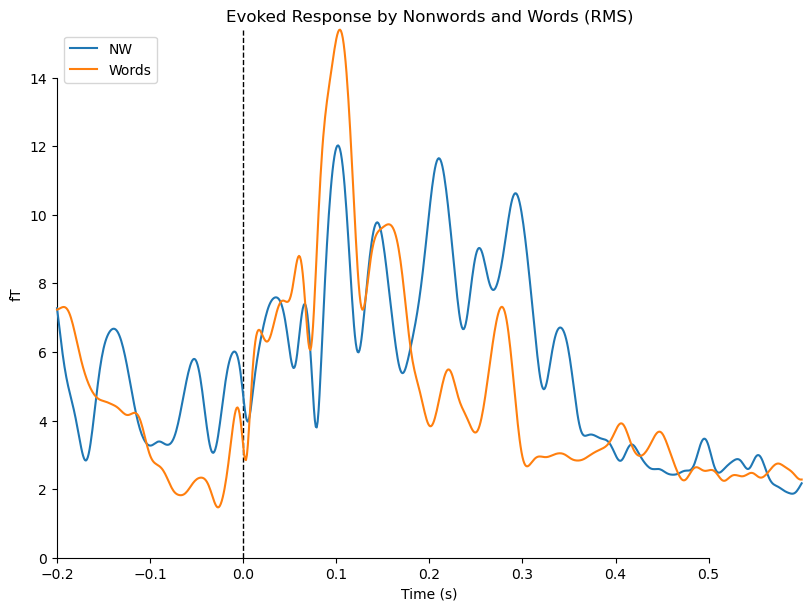

In [26]:
import matplotlib.pyplot as plt

nw_group = []
words_group = []

# Categorize conditions
for i, condition in enumerate(conditions):
    if 'NW' in condition:
        nw_group.append(i)
    else:
        words_group.append(i)

# Calculate average waveforms for NW and Words groups
average_waveforms = {}
average_waveforms['NW'] = epochs_data[nw_group].mean(axis=0).mean(axis=0)  # average across the condition and epoch axes
average_waveforms['Words'] = epochs_data[words_group].mean(axis=0).mean(axis=0)  # average across the condition and epoch axes

# Create EvokedArray for each group
evoked_dict = {}
for group, data in average_waveforms.items():
    evoked_dict[group] = mne.EvokedArray(data, info, tmin=times[0])

fig = mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='Evoked Response by Nonwords and Words')
fig[0].savefig('wordness.pdf')

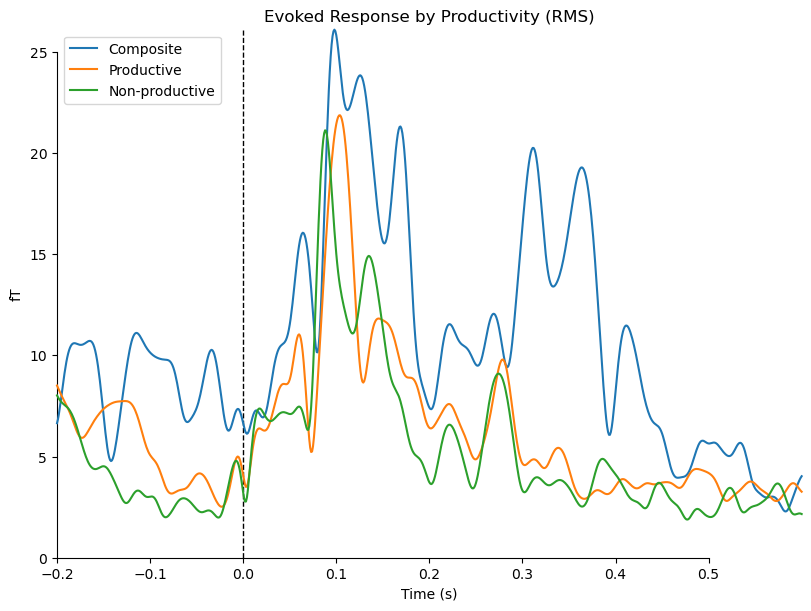

In [27]:
import matplotlib.pyplot as plt

composite_group = []
with_lat_group = []
without_lat_group = []

for i, condition in enumerate(conditions):
    if 'Composite' in condition:
        composite_group.append(i)
    elif 'w/ Lat.' in condition:
        with_lat_group.append(i)
    elif 'w/o Lat.' in condition:
        without_lat_group.append(i)

average_waveforms = {}
average_waveforms['Composite'] = epochs_data[composite_group].mean(axis=0).mean(axis=0)  # average across the condition and epoch axes
average_waveforms['Productive'] = epochs_data[with_lat_group].mean(axis=0).mean(axis=0)  # average across the condition and epoch axes
average_waveforms['Non-productive'] = epochs_data[without_lat_group].mean(axis=0).mean(axis=0)

evoked_dict = {}
for group, data in average_waveforms.items():
    evoked_dict[group] = mne.EvokedArray(data, info, tmin=times[0])

fig = mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='Evoked Response by Productivity')
fig[0].savefig('productivity.pdf')

### Create X

In [28]:
X = epochs_data.copy()
print(X.shape)

# extract time window of interest
idx_tmin = np.where(times == tmin)[0][0]
idx_tmax = np.where(times == tmax)[0][0]
X = X[:, :, :, idx_tmin : idx_tmax + 1]
print(X.shape)

# create array of times for the search window: needed to get cluster times later
search_window = np.arange(tmin, tmax+1, 0.001)
# print(search_window)

# transpose for permutation test later
X = X.transpose(0, 1, 3, 2)
print(X.shape)

# # average over space
# X = X.mean(axis=3)
# print(X.shape)

# # convert to a list of len = num_conditions, each element of the list is an array of shape (nsubj x ntimes)
X = [np.squeeze(x) for x in np.split(X, 4, axis=1)]
print(len(X))
print(X[0].shape)

(24, 12, 207, 801)
(24, 12, 207, 501)
(24, 12, 501, 207)
4
(24, 3, 501, 207)


### Set up test

In [29]:
### if doing spatio-temp search, add adjacency
def stat_fun(*args):
    # Return only the F-values
    return f_mway_rm(np.swapaxes(args, 1, 0), factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]

#adjacency, ch_names = mne.channels.find_ch_adjacency(info, ch_type='mag')
hemi = 'lh'

In [ ]:
# Estimating F-test threshold
factor_levels = [] # condition contrasts
effects = ['A:B'] # A - main effect of A, B - main effect of B, A:B - interaction effect
f_thresh = f_threshold_mway_rm(len(subjects), factor_levels, effects, p_thresh)

print("Conditions: ", conditions)
print("Time window of analysis: ", tmin, " to ", tmax)
print("Launching clustering test for effect:", effects)
print("Threshold:", f_thresh)

# Perform the clustering test
F_obs, clusters, clusters_pvals, h0 = clu = mne.stats.permutation_cluster_test(X, #spatio_temporal_cluster_test
                                            tail=tail,                                   
                                            threshold=f_thresh,
                                            stat_fun = stat_fun,
                                            n_permutations=n_permutations,
                                            # adjacency = adjacency,
                                            out_type='indices',
                                            n_jobs=-1)

# Check outputs
print("Cluster p-values:", clusters_pvals)
for cluster, pval in zip(clusters, clusters_pvals):
    #print(cluster)
    if pval < p_thresh:
        cluster_start_time = search_window[cluster[0][0]]
        cluster_end_time = search_window[cluster[0][-1]]
        if len(search_window[cluster[0]]) > 30:
            print("%s - %s ms, p-value: %s" % (cluster_start_time, cluster_end_time, pval))

---

### plotting code

(4, 157, 901)
0.266 - 0.28400000000000003 ms, p-value: 0.2029


/state/partition1/job-47316322/ipykernel_3842899/1208761965.py:11: RuntimeWarning: (X, Y) fit (-96.7, 61.1) more than 20 mm from head frame origin
  mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='', axes = ax, show=False) #, colors=colors


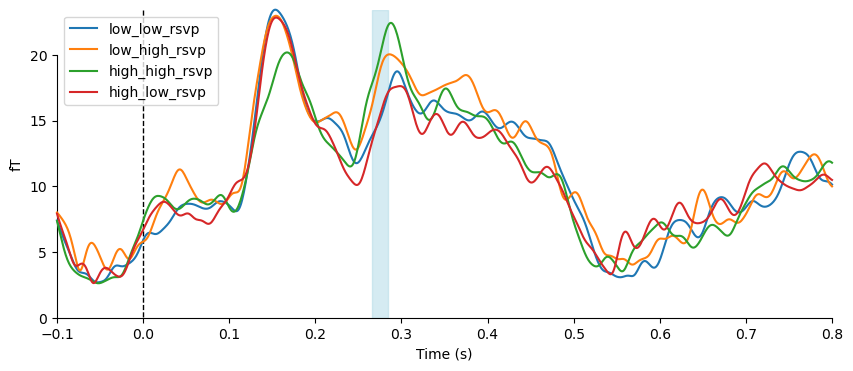

In [52]:
average_waveforms = epochs_data.mean(axis=0)  # average across the subject axis

print(average_waveforms.shape)

evoked_dict = {}
for i, condition in enumerate(conditions):
    evoked_dict[condition] = mne.EvokedArray(average_waveforms[i], info, tmin=times[0])

# break down compare evokeds plot
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
mne.viz.plot_compare_evokeds(evoked_dict, combine='gfp', title='', axes = ax, show=False) #, colors=colors
for cluster, pval in zip(clusters, clusters_pvals):
    if pval < 0.35:
        cluster_start_time = search_window[cluster[0][0]]
        cluster_end_time = search_window[cluster[0][-1]]
        if len(search_window[cluster[0]]) > 1:
            ax.axvspan(cluster_start_time, cluster_end_time,color='lightblue', alpha=0.5)
            print("%s - %s ms, p-value: %s" % (cluster_start_time, cluster_end_time, pval))

plt.show()
# fig.savefig("rsvp_0-0.5_B.pdf")

---

In [ ]:
for ind in cluster_end_time:
    print(ind)

In [ ]:
X_avg = np.mean(X, axis=(0,1))
X_avg.shape

In [ ]:
import numpy as np
from scipy.stats import ttest_rel

group1 = X_avg[:, :2]  
group2 = X_avg[:, 2:]  

t_stat, p_value = ttest_rel(group1, group2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

In [ ]:
def stat_fun(*args):
    return f_mway_rm(np.swapaxes(args, 1, 0), factor_levels=factor_levels, effects=effects, return_pvals=False)[0]